### Projekt zaliczeniowy.

Uniwersytet Ekonomiczny we Wrocławiu.
DATA SCIENCE - Zaawansowana analiza danych.

I semestr.

$Paweł~Tometczak$


W projekcie przeanalizowano dane dotyczące przedsiębiorstwa $XXX$ sprzedajacego produkty różnego rodzaju. Poddano analizie wartość dokonanych zakupów w kolejnych latach - podział na płeć, sprzedaż w kontekście analizy zarówno ilościowej, jak i jakościowej, a także popularność miast sprzedaży i poszczególne produkty, pod kątem ich udziału zarówno w wielkości sprzedaży, jak i w przychodach przedsiębiorstwa. Określono sezonowość sprzedaż w poszczególnych latach w rozłożeniu na miesiące.

Zaczynamy od wczytania potrzebnych pakietów i bibliotek:

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from scipy.stats import kstest
from scipy import stats
from scipy.stats import skew
import random
import matplotlib.pyplot as plt
%matplotlib inline

Zmieniam precyzję wyświetlania liczb zmiennoprzecinkowych, liczby będą wyświetlane w Pandas z precyzją do trzech miejsc po przecinku:

In [16]:
pd.set_option('float_format', '{:.3f}'.format)

### Wczytanie danych i oczyszczenie, normalizacja tabel dla wygodniejszej dalszej pracy:

In [17]:
products_raw = pd.read_csv("products.txt", sep='\t', engine='python', index_col = 'PRODUCTID')
products_raw.columns = products_raw.columns.str.lower()
products_raw.index.name = products_raw.index.name.lower()
    
customers_raw = pd.read_csv("customers.txt", sep='\t', engine='python', index_col = 'customerid')

orders_raw = pd.read_csv("orders.txt", encoding='cp1251', sep='\t', engine='python')
orders_raw.orderdate = pd.to_datetime(orders_raw.orderdate)

orderlines_raw = pd.read_csv("orderlines.txt",delimiter="\t", encoding="cp1251",  index_col='orderlineid')
orderlines_raw.shipdate = pd.to_datetime(orderlines_raw.shipdate)
orderlines_raw.billdate = pd.to_datetime(orderlines_raw.billdate)
orderlines_raw['year'] = orderlines_raw.shipdate.dt.year

#dane dodatkowe do analizy dużej bazy (littleBigData) - TABELE
calendar_raw_bd = pd.read_csv("calendar.txt", encoding='cp1251', sep='\t',low_memory=False)
campaigns_raw_bd = pd.read_csv("campaigns.txt", encoding='cp1251', sep='\t',low_memory=False)
zip1_raw_bd = pd.read_csv("ZipCensus.txt", encoding='cp1251', sep='\t',low_memory=False)
zip2_raw_bd = pd.read_csv("zipcounty.txt", encoding='cp1251', sep='\t',low_memory=False)

products_raw_bd = products_raw.reset_index()
customers_raw_bd = customers_raw.reset_index()
orders_raw_bd = orders_raw

BigData = pd.merge(orders_raw_bd, customers_raw_bd, on='customerid', how='outer')

In [18]:
# połączenie dataframe products i orderline. Metoda łączenia: INNER JOIN i klucz: 'productid'
orderlines_raw_bd = pd.read_csv("orderlines.txt",delimiter="\t", encoding="cp1251")
little_data = pd.merge(orderlines_raw_bd, products_raw_bd, on='productid', how='inner')

# ujednolicenie wielkości liter w nazwach kolumn zbiorów produktów i pozycji zamówień
products_raw_bd.columns = map(str.lower, products_raw_bd.columns)

BigData = pd.merge(little_data, BigData, on='orderid', how='inner')

differenc_table = BigData.numorderlines != BigData.numunits_y
BigData[differenc_table].head(3)

,orderlineid,orderid,productid,shipdate,billdate,unitprice,numunits_x,totalprice_x,productname,productgroupcode,...,city,state,zipcode,paymenttype,totalprice_y,numorderlines,numunits_y,householdid,gender,firstname
9,1010628,1010318,10834,2010-12-09 00:00:00,2010-12-10 00:00:00,25.000,2,50.000,nan,BK,...,HONOLULU,HI,96816,AE,80.000,3,4,20327232.000,F,LINDA
10,1010664,1010318,10930,2010-12-09 00:00:00,2010-12-10 00:00:00,16.000,1,16.000,nan,BK,...,HONOLULU,HI,96816,AE,80.000,3,4,20327232.000,F,LINDA
11,1010663,1010318,11176,2010-12-09 00:00:00,2010-12-10 00:00:00,14.000,1,14.000,nan,BK,...,HONOLULU,HI,96816,AE,80.000,3,4,20327232.000,F,LINDA


In [19]:
#dodanie kolumn z miesiącami i latami
BigData.shipdate = pd.to_datetime(BigData.shipdate)
BigData.billdate = pd.to_datetime(BigData.billdate)
BigData['year'] = BigData.shipdate.dt.year

BigData.shipdate = pd.to_datetime(BigData.shipdate)
BigData.billdate = pd.to_datetime(BigData.billdate)
BigData['month'] = BigData.shipdate.dt.month
BigData.head(1)

,orderlineid,orderid,productid,shipdate,billdate,unitprice,numunits_x,totalprice_x,productname,productgroupcode,...,zipcode,paymenttype,totalprice_y,numorderlines,numunits_y,householdid,gender,firstname,year,month
0,1010561,1006414,10834,2011-03-07,2011-03-08,18.000,1,18.000,nan,BK,...,35222,MC,36.000,2,2,18335614.000,M,LAWRENCE,2011,3


In [20]:
#sprawdzam jakiego typu zmienne występują w zbiorze (zmienne całkowite,
#zmiennoprzecinkowe, kategoryczne porządkowe, kategoryczne nominalne, zmienne typu logicznego, daty).
BigData.dtypes

orderlineid                  int64
orderid                      int64
productid                    int64
shipdate            datetime64[ns]
billdate            datetime64[ns]
unitprice                  float64
numunits_x                   int64
totalprice_x               float64
productname                float64
productgroupcode            object
productgroupname            object
instockflag                 object
fullprice                    int64
customerid                   int64
campaignid                   int64
orderdate           datetime64[ns]
city                        object
state                       object
zipcode                     object
paymenttype                 object
totalprice_y               float64
numorderlines                int64
numunits_y                   int64
householdid                float64
gender                      object
firstname                   object
year                         int64
month                        int64
dtype: object

In [21]:
#podstawowe podsumowanie zbioru BigData
BigData.describe()

,orderlineid,orderid,productid,unitprice,numunits_x,totalprice_x,productname,fullprice,customerid,campaignid,totalprice_y,numorderlines,numunits_y,householdid,year,month
count,286017.000,286017.000,286017.000,281033.000,286017.000,286017.000,0.000,286017.000,286017.000,286017.000,286017.000,286017.000,286017.000,280853.000,286017.000,286017.000
mean,1263250.717,1177575.023,11715.231,46.276,1.522,47.930,nan,59.133,94674.038,2171.538,114.632,2.532,19.502,31205078.314,2013.195,7.535
std,263224.666,164557.245,989.714,105.623,14.691,109.548,nan,160.921,56328.384,51.972,406.538,5.572,487.557,13133709.032,1.888,3.856
min,1000001.000,999992.000,10001.000,0.000,0.000,0.000,nan,0.000,0.000,2001.000,0.000,1.000,1.000,18111489.000,2009.000,1.000
25%,1071505.000,1055595.000,11014.000,10.000,1.000,10.050,nan,14.000,45933.000,2141.000,18.000,1.000,1.000,19885296.000,2012.000,4.000
50%,1143009.000,1109353.000,11179.000,17.500,1.000,18.000,nan,24.000,94074.000,2173.000,29.950,2.000,2.000,23509782.000,2014.000,8.000
75%,1408147.000,1263197.000,12719.000,27.310,1.000,30.000,nan,33.000,144078.000,2236.000,69.950,3.000,3.000,36213864.000,2015.000,11.000
max,2017159.000,1643157.000,14040.000,6250.000,3000.000,6780.000,nan,6250.000,189559.000,2239.000,9848.960,150.000,19527.000,81810420.000,2016.000,12.000


In [22]:
#sprawdzam czy w zbiorze występują braki danych
nulls_summary = pd.DataFrame(BigData.isnull().any(), columns=['Nulls'])
nulls_summary['Braki danych [ilość]'] = pd.DataFrame(BigData.isnull().sum())
nulls_summary['Braki danych [%]'] = round((BigData.isnull().mean()*100),2)
nulls_summary

,Nulls,Braki danych [ilość],Braki danych [%]
orderlineid,False,0,0.000
orderid,False,0,0.000
productid,False,0,0.000
shipdate,False,0,0.000
billdate,False,0,0.000
unitprice,True,4984,1.740
numunits_x,False,0,0.000
totalprice_x,False,0,0.000
productname,True,286017,100.000
productgroupcode,False,0,0.000


### Wyznaczam współczynniki skośności poszczególnych zmiennych numerycznych.





$$\Large {współczynnik}~{skośności} = 3 * \frac{średnia - mediana}{odchylenie~standardowe}$$



Współczynnik o wartości $0$, to rozkład symetryczny.
Współczynnik o wartości ujemnej to rozkład lewostronnie skośny (wydłużone lewe ramię rozkładu; średnia mniejsza od mediany).
Współczynnik o wartości dodatniej to rozkład prawostronnie skośny (wydłużone prawe ramię rozkładu; średniej większa od mediany).



In [23]:
#skośność rozkładów, oczywiście interesują mnie zmienne numeryczne, które pozwolą na analizę
BigData.skew()

orderlineid      1.193
orderid          1.131
productid        0.449
unitprice        8.937
numunits_x      91.851
totalprice_x     9.869
productname        nan
fullprice       13.131
customerid      -0.029
campaignid      -0.545
totalprice_y    12.405
numorderlines   17.505
numunits_y      32.370
householdid      0.876
year            -0.482
month           -0.331
dtype: float64

### Obserwacje odstające
Zgodnie z regułą, obserwacją odstającą jest obserwacja, która przyjmuje wartość:
Większą niż półtora odstępu międzykwartylowego $(Q3 – Q1)$, od trzeciego kwartyla$(Q3)$.
Mniejszą niż półtora odstępu międzykwartylowego $(Q3 – Q1)$, od pierwszego kwartyla$(Q1)$.

In [24]:
#sprawdzam gdzie występują wartości odstające
Q_first = BigData.quantile(0.25)
Q_third = BigData.quantile(0.75)
iqr = Q_third-Q_first
low_boundary = (Q_first - 1.5 * iqr)
upp_boundary = (Q_third + 1.5 * iqr)
num_of_outliers_L = (BigData[iqr.index] < low_boundary).sum()
num_of_outliers_U = (BigData[iqr.index] > upp_boundary).sum()
wartosci_odstajace = pd.DataFrame({'niska_granica':low_boundary, 'wysoka_granica':upp_boundary,\
                         'wartosci_odstajace_L':num_of_outliers_L, 'wartosci_odstajace_U':num_of_outliers_U}) 
wartosci_odstajace

,niska_granica,wysoka_granica,wartosci_odstajace_L,wartosci_odstajace_U
orderlineid,566542.000,1913110.000,0,8763
orderid,744192.000,1574600.000,0,9580
productid,8456.500,15276.500,0,0
unitprice,-15.965,53.275,0,38744
numunits_x,1.000,1.000,4984,19920
totalprice_x,-19.875,59.925,0,40540
productname,nan,nan,0,0
fullprice,-14.500,61.500,0,40996
customerid,-101284.500,291295.500,0,0
campaignid,1998.500,2378.500,0,0


In [25]:
#sprawdzam liczności zmiennych kategorycznych 
for col in BigData.select_dtypes(['object', 'category']):
    print(BigData[col].value_counts()) 

BK    113210
AR     56498
OC     41713
FR     28073
GA     18469
AP     12348
CA      9872
OT      5825
#N         9
Name: productgroupcode, dtype: int64
BOOK        113210
ARTWORK      56498
OCCASION     41713
FREEBIE      28073
GAME         18469
APPAREL      12348
CALENDAR      9872
OTHER         5825
Name: productgroupname, dtype: int64
Y    172786
N    113231
Name: instockflag, dtype: int64
NEW YORK               27309
BROOKLYN                5639
CHICAGO                 3441
WASHINGTON              3101
SAN FRANCISCO           2645
                       ...  
ROCKAWAY POINTS            1
GROSSE POINTS FARMS        1
SNATA FE                   1
FT SAM HOUSTON             1
RAWLINS                    1
Name: city, Length: 12822, dtype: int64
NY    78979
NJ    31163
CA    26445
FL    15202
CT    13750
      ...  
CN        1
MG        1
NL        1
DF        1
BD        1
Name: state, Length: 91, dtype: int64
10021    3480
10036    3448
10023    1874
10024    1780
10128    1711
  

### Dane klientów

In [26]:
#customers_raw - czyszczenie danych
customers_raw.head()

,householdid,gender,firstname
customerid,,,
174596,53949999,M,DANIEL
68239,49927024,M,JIM
10203,20914414,F,DONNA
174288,53957047,F,DIONE
68099,49927024,M,JIM


In [28]:
# INFO-Data Frame, w którym znajdują się wszystkie niezbędne informacje:
# nazwa zmiennej, informacja o jej typie,
#informacja czy dana zmienna zawiera braki,
#liczba braków, oraz procentowa brakującyh wartości w zmiennej

info1 = pd.DataFrame(customers_raw.dtypes, columns=['Dtype'])
info1['Nulls'] = pd.DataFrame(customers_raw.isnull().any())
info1['Sum_of_nulls'] = pd.DataFrame(customers_raw.isnull().sum())
info1['Per_of_nulls'] = round((customers_raw.apply(pd.isnull).mean()*100),2)
info1.Dtype = info1.Dtype.astype(str)
info1

,Dtype,Nulls,Sum_of_nulls,Per_of_nulls
householdid,int64,False,0,0.000
gender,object,True,16204,8.550
firstname,object,True,2915,1.540


In [29]:
customers = customers_raw.dropna()
customers.head()
#customers zmienna ostateczna zbioru customers.txt

,householdid,gender,firstname
customerid,,,
174596,53949999,M,DANIEL
68239,49927024,M,JIM
10203,20914414,F,DONNA
174288,53957047,F,DIONE
68099,49927024,M,JIM


#### 1.2 - Dane o produktach

In [30]:
#products_raw sprawdzanie i  czyszczenie danych po wybraniu kolumn
products_raw.head()

,productname,productgroupcode,productgroupname,instockflag,fullprice
productid,,,,,
10001,nan,CA,CALENDAR,N,15
10002,nan,CA,CALENDAR,N,10
10003,nan,CA,CALENDAR,N,10
10004,nan,BK,BOOK,Y,90
10005,nan,BK,BOOK,Y,16


In [32]:
info2 = pd.DataFrame(products_raw.dtypes, columns=['Dtype'])
info2['Nulls'] = pd.DataFrame(products_raw.isnull().any())
info2['Sum_of_nulls'] = pd.DataFrame(products_raw.isnull().sum())
info2['Per_of_nulls'] = round((products_raw.apply(pd.isnull).mean()*100),2)
info2.Dtype = info2.Dtype.astype(str)
info2

,Dtype,Nulls,Sum_of_nulls,Per_of_nulls
productname,float64,True,4040,100.000
productgroupcode,object,False,0,0.000
productgroupname,object,True,1,0.020
instockflag,object,False,0,0.000
fullprice,int64,False,0,0.000


In [33]:
#sprawdzam jakie kolumny zawiera Data Frame
products_raw.columns

Index(['productname', 'productgroupcode', 'productgroupname', 'instockflag',
       'fullprice'],
      dtype='object')

In [34]:
#wybieram interesujące mnie kolumny
products_df = products_raw[['productgroupcode','productgroupname', 'fullprice']]#, 'instockflag'
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 10001 to 14040
Data columns (total 3 columns):
productgroupcode    4040 non-null object
productgroupname    4039 non-null object
fullprice           4040 non-null int64
dtypes: int64(1), object(2)
memory usage: 126.2+ KB


In [35]:
products_df.head()
#products_df zmienna ostateczna zbioru products.txt

,productgroupcode,productgroupname,fullprice
productid,,,
10001,CA,CALENDAR,15
10002,CA,CALENDAR,10
10003,CA,CALENDAR,10
10004,BK,BOOK,90
10005,BK,BOOK,16


### Dane o zamówieniach

In [36]:
# orders_raw- czyszczenie danych
orders_raw.head()

,orderid,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits
0,1002854,45978,2141,2009-10-13,NEWTON,MA,02459,VI,190.000,3,3
1,1002855,125381,2173,2009-10-13,NEW ROCHELLE,NY,10804,VI,10.000,1,1
2,1002856,103122,2141,2011-06-02,MIAMI,FL,33137,AE,35.220,2,2
3,1002857,130980,2173,2009-10-14,E RUTHERFORD,NJ,07073,AE,10.000,1,1
4,1002886,48553,2141,2010-11-19,BALTIMORE,MD,21218,VI,10.000,1,1


In [38]:
info3 = pd.DataFrame(orders_raw.dtypes, columns=['Dtype'])
info3['Nulls'] = pd.DataFrame(orders_raw.isnull().any())
info3['Sum_of_nulls'] = pd.DataFrame(orders_raw.isnull().sum())
info3['Per_of_nulls'] = round((orders_raw.apply(pd.isnull).mean()*100),2)
info3.Dtype = info3.Dtype.astype(str)
info3

,Dtype,Nulls,Sum_of_nulls,Per_of_nulls
orderid,int64,False,0,0.000
customerid,int64,False,0,0.000
campaignid,int64,False,0,0.000
orderdate,datetime64[ns],False,0,0.000
city,object,True,19,0.010
state,object,True,1119,0.580
zipcode,object,True,146,0.080
paymenttype,object,False,0,0.000
totalprice,float64,False,0,0.000
numorderlines,int64,False,0,0.000


In [39]:
#procentowa znikomość niepełnych danych
orders = orders_raw.dropna()
orders.head()
#orders ostateczna zmienna orders.txt

,orderid,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits
0,1002854,45978,2141,2009-10-13,NEWTON,MA,02459,VI,190.000,3,3
1,1002855,125381,2173,2009-10-13,NEW ROCHELLE,NY,10804,VI,10.000,1,1
2,1002856,103122,2141,2011-06-02,MIAMI,FL,33137,AE,35.220,2,2
3,1002857,130980,2173,2009-10-14,E RUTHERFORD,NJ,07073,AE,10.000,1,1
4,1002886,48553,2141,2010-11-19,BALTIMORE,MD,21218,VI,10.000,1,1


In [40]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191846 entries, 0 to 192982
Data columns (total 11 columns):
orderid          191846 non-null int64
customerid       191846 non-null int64
campaignid       191846 non-null int64
orderdate        191846 non-null datetime64[ns]
city             191846 non-null object
state            191846 non-null object
zipcode          191846 non-null object
paymenttype      191846 non-null object
totalprice       191846 non-null float64
numorderlines    191846 non-null int64
numunits         191846 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 17.6+ MB


### Dane o liście zamówień 

In [41]:
orderlines_raw.head()

,orderid,productid,shipdate,billdate,unitprice,numunits,totalprice,year
orderlineid,,,,,,,,
1010561,1006414,10834,2011-03-07,2011-03-08,18.000,1,18.000,2011
1010562,1006541,11052,2011-01-19,2011-01-20,10.000,2,20.000,2011
1010563,1006542,11070,2011-01-19,2011-01-20,19.120,1,19.120,2011
1010564,1010154,11196,2009-11-19,2009-11-20,14.950,1,14.950,2009
1010565,1009110,11048,2009-11-11,2009-11-12,10.000,2,20.000,2009


In [42]:
info4 = pd.DataFrame(orderlines_raw.dtypes, columns=['Dtype'])
info4['Nulls'] = pd.DataFrame(orderlines_raw.isnull().any())
info4['Sum_of_nulls'] = pd.DataFrame(orderlines_raw.isnull().sum())
info4['Per_of_nulls'] = round((orderlines_raw.apply(pd.isnull).mean()*100),2)
info4.Dtype = info4.Dtype.astype(str)
info4

,Dtype,Nulls,Sum_of_nulls,Per_of_nulls
orderid,int64,False,0,0.000
productid,int64,False,0,0.000
shipdate,datetime64[ns],False,0,0.000
billdate,datetime64[ns],False,0,0.000
unitprice,float64,True,4984,1.740
numunits,int64,False,0,0.000
totalprice,float64,False,0,0.000
year,int64,False,0,0.000


In [43]:
orderlines = orderlines_raw.dropna()
orderlines.info()
#ostateczna zmienna orderlines.txt

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281033 entries, 1010561 to 2017159
Data columns (total 8 columns):
orderid       281033 non-null int64
productid     281033 non-null int64
shipdate      281033 non-null datetime64[ns]
billdate      281033 non-null datetime64[ns]
unitprice     281033 non-null float64
numunits      281033 non-null int64
totalprice    281033 non-null float64
year          281033 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 19.3 MB


##  Statystyki podstawowe

####  Płeć klientów

Spośród wszystkich klientów przedsiębiorstwa 55,7% stanowią mężczyźni a 44,3% kobiety. 
Dane dotyczące płci klientów zostały przedstawione w postaci wykresu kołowego z zaznaczeniem etykiet danych.

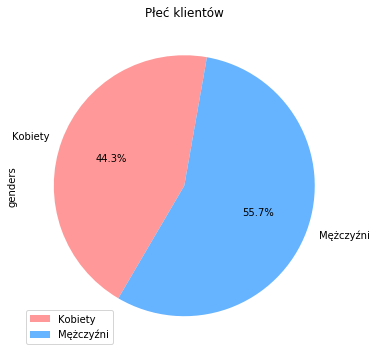

In [44]:
plec = {"Mężczyźni":customers.gender[customers.gender == "M"].count(),"Kobiety": customers.gender[customers.gender == "F"].count()}
plec_df = pd.DataFrame({"genders": plec})
plec_df.plot.pie(subplots=True,  figsize=(6,6),  autopct='%1.1f%%', colors = ['#ff9999', '#66b3ff'],startangle=80)
_ = plt.title('Płeć klientów')

In [45]:
#łączę pliki customers i orders, dodając kolumny z latami i miesiącami
customers_and_orders = pd.merge(customers, orders, on="customerid")
customers_and_orders = customers_and_orders.dropna()
customers_and_orders['month'] = orders['orderdate'].dt.month
customers_and_orders['year'] = orders['orderdate'].dt.year
customers_and_orders = customers_and_orders.dropna()
customers_and_orders["year"] = customers_and_orders["year"].astype("int64")
customers_and_orders["month"] = customers_and_orders["month"].astype("int64")

In [46]:
customers_and_orders.head(2)

,customerid,householdid,gender,firstname,orderid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits,month,year
0,174596,53949999,M,DANIEL,1391159,2204,2015-09-27,MONTVALE,NJ,07645,AE,44.950,1,1,10,2009
1,68239,49927024,M,JIM,1391160,2237,2015-09-24,NEW YORK,NY,10036,DB,0.000,1,100,10,2009


### Sprzedaż kolejnych latach - podział na płeć

W latach 2009-2011 sprzedaż w firmie $XXX$ wyraźnie rosła. W $2012$ roku sprzedaż była na stałym poziomie i zaczęła podnosić się w latach $2013-2014$. Od roku $2015$ zaobserwowana spadek sprzedaży.
Przez wszystkie lata udział mężczyzn w zakupach był większy niż kobiet.

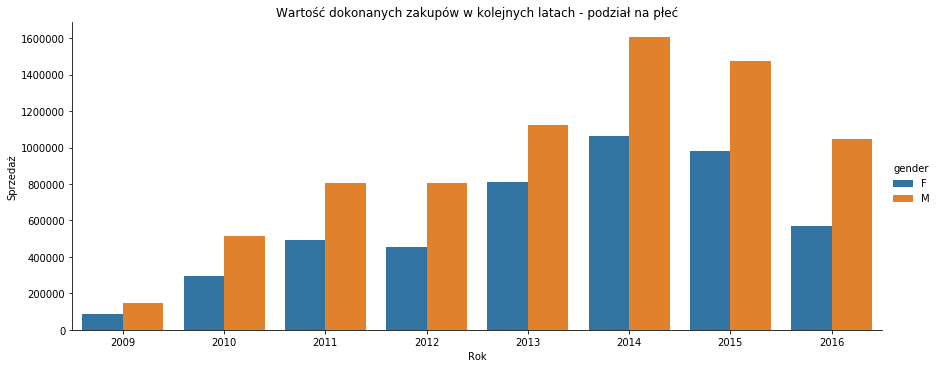

In [47]:
plot1=BigData.groupby(['year', 'gender']).sum().loc[2009:2016].totalprice_x
plot1_a = pd.DataFrame(plot1)
sw = plot1_a.reset_index()

_= sns.catplot(x= "year", data  = sw, y="totalprice_x",\
                                     hue = "gender",kind="bar",aspect=2.5)\
.set(title = 'Wartość dokonanych zakupów w kolejnych latach - podział na płeć'\
     , ylabel = 'Sprzedaż', xlabel = 'Rok' )

In [48]:
#zyski w kolejnych latach
year_total_price = orderlines.loc[:, ["year", "totalprice"]].groupby('year').sum().reset_index()
year_total_price.head(8)

,year,totalprice
0,2009,257158.770
1,2010,907805.260
2,2011,1424813.410
3,2012,1396537.580
4,2013,2158385.800
5,2014,2962670.460
6,2015,2776533.760
7,2016,1824991.260


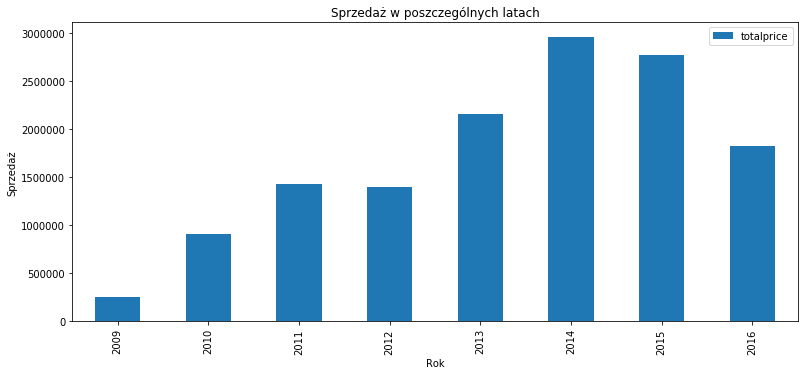

In [49]:
_ =year_total_price.plot(x = "year", y = "totalprice" ,kind="bar",figsize=(13,5.5))\
.set(title = 'Sprzedaż w poszczególnych latach',\
ylabel = 'Sprzedaż', xlabel = 'Rok')

### Sprzedaż kolejnych latach

Wyraźnie można zaobserwować sezonowość sprzedaży w poszczególnych miesiącah. Szczególnie widoczne to jesr w grudniu od $2013$ roku. 

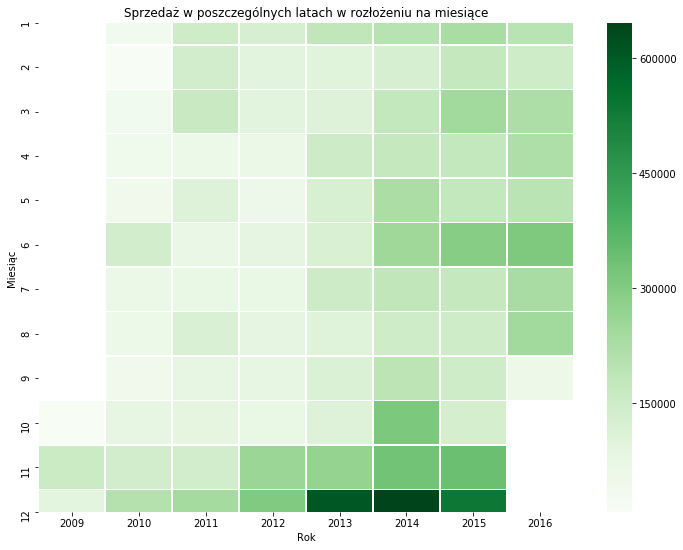

In [50]:
#sprzedaż w poszczególnych latach z podziałem na miesiące
plot2=BigData.groupby(['year', 'month']).sum().loc[2009:2016].totalprice_x
plot2_a = pd.DataFrame(plot2)
sw2 = plot2_a.reset_index()
sw2=sw2.pivot("month", "year", "totalprice_x")

f, ax = plt.subplots(figsize=(12, 9))
_=sns.heatmap(sw2, annot=False, linewidths=.5, ax=ax, cmap="Greens")\
.set(title = 'Sprzedaż w poszczególnych latach w rozłożeniu na miesiące',\
ylabel = 'Miesiąc', xlabel = 'Rok')

### Sprzedaż z podziałem na grupy produktów

Najczęściej kupowanym produktem były te z grupy $ARTWORK$, łącznie sprzedano ich za kwotę $1~427~905$ dolarów. Jest to też produkt, którego średnia cena jest najwyższa.
Najmniej dochodowym artykułem są produkty z grupy $CALENDAR$.


In [51]:
#ilość zamówień (grupowanie wg produktu)
select = ["productgroupname","fullprice","numorders"]
orders_a = orderlines_raw.groupby("productid").agg({"orderid" : "nunique"}).rename(columns={'orderid': 'numorders'})
product_orders = pd.merge(orders_a, products_df, on ="productid")[select]
product_orders.sort_values(by = "numorders")
product_orders = product_orders[product_orders.fullprice != 0]
product_orders.head()

,productgroupname,fullprice,numorders
productid,,,
10001,CALENDAR,15,253
10002,CALENDAR,10,229
10003,CALENDAR,10,168
10004,BOOK,90,34
10005,BOOK,16,1687


In [52]:
#pogrupowanie produktów ze względu na rodzaj i obliczenia odnośnie ceny
product_ordersA = product_orders.groupby("productgroupname").agg({'fullprice': [np.mean, np.std,np.median, np.sum]})
product_ordersA

fullprice                        
                      mean     std median      sum
productgroupname                                  
APPAREL             23.349   9.828     19     2008
ARTWORK            432.698 363.453    340  1427905
BOOK                40.938 231.354     20     9825
CALENDAR            40.032 109.974     14     1241
GAME                11.268   9.822      9     2603
OCCASION            24.155  10.644     24     1715
OTHER               29.585  21.999     24     1213

Średnią arytmetyczną ciągu wartości $x_1, \dots, x_n$ nazwyamy:
$$\Large\bar{x}= \frac{x_{1} + x_{2} + \ \ldots \ + x_{n}}{n} = \frac{1}{n} \sum_{i=1}^{n} x_{i}$$  


Medianą ciągu wartości $x_1, \dots, x_n$ nazywamy środkowy wyraz tego ciągu, gdy $n$ jest liczbą nieparzystą, w przeciwnym przypadku średnią arytmetyczną dwóch wyrazów środkowych.

$\Large Mediana = Me = \left\{\begin{array} {lll} x_{(k+1)} &  \hbox{ dla } & n=2k+1 \\[1mm] \frac{x_{(k)}+x_{(k+1)}}{2} & \hbox{ dla } & n=2k. \end{array} \right.$,
gdzie $x_{(1)} \le x_{(2)} \le  \dots \le x_{(n)}.$  


Odchyleniem standardowym ciągu $x_1, \dots, x_n$ nazywamy wartość:

$$\Large s_n = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ( x_{i}-\bar{x})^{2}}$$

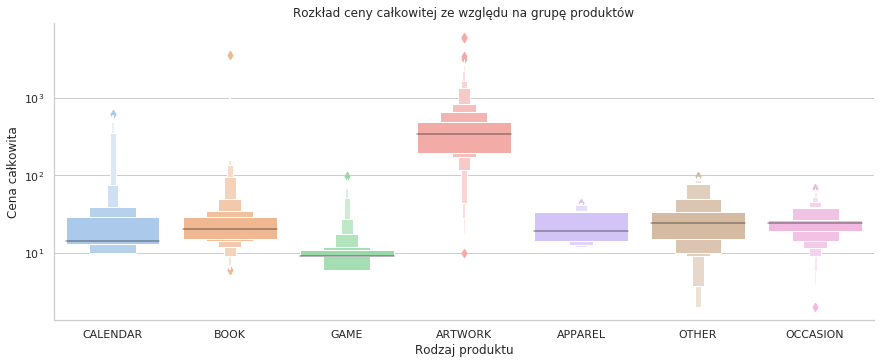

In [53]:
#wykres pudełkowy - produkty i cena całkowita
sns.set(style="whitegrid", palette="pastel")
_=sns.catplot(x ="productgroupname", y ="fullprice", kind="boxen",aspect=2.5,
            data =product_orders ).set(yscale="log")\
.set(title = 'Rozkład ceny całkowitej ze względu na grupę produktów'\
     , ylabel = 'Cena całkowita', xlabel = 'Rodzaj produktu' )

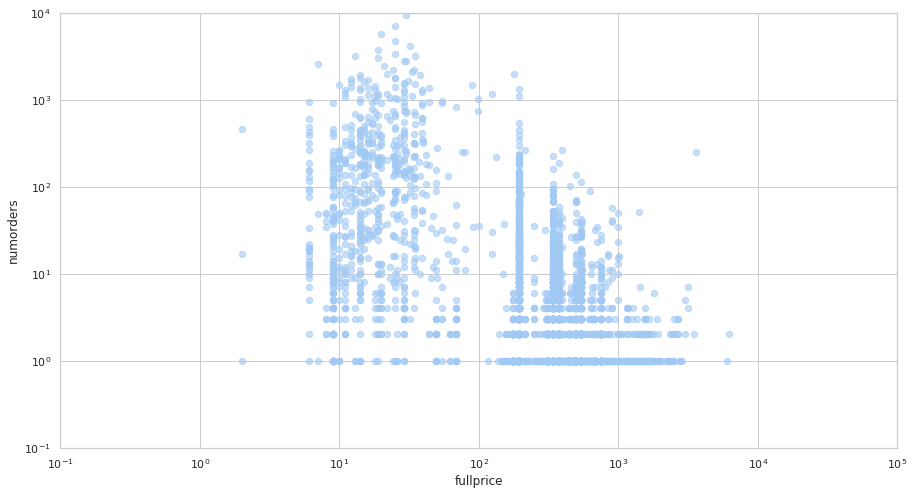

In [54]:
#ilość artykułów a cena do zapłaty
_ =product_orders.plot(y = "numorders", x = "fullprice" , kind="scatter", s=40, figsize=(15,8), 
                     xlim =[0.1, 100000], ylim =[0.1,10000],
                     loglog= True,alpha=0.6, color = 'b')

In [55]:
# produkty z podziałem na rok
select = ["productid","year","productgroupname"]
product_years = pd.merge(products_df, orderlines, on ="productid")[select].groupby(["year","productgroupname"]).agg({"productid" : "count"}) \
.rename(columns={'productid': 'count'}).sort_values(by =["year","productgroupname"])

product_years.head()

count
year productgroupname       
2009 APPAREL              15
     ARTWORK            4835
     BOOK               3917
     CALENDAR             15
     OCCASION           1112

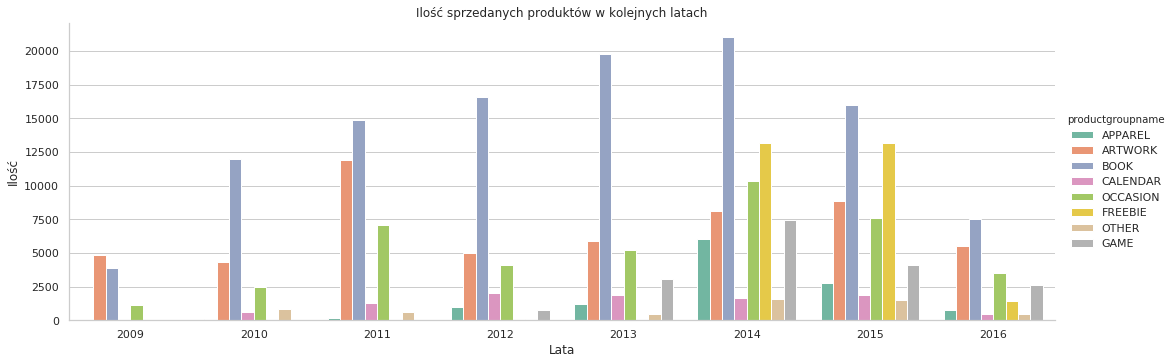

In [56]:
#ilość sprzedanych produktów z poszczególnych kategorii na przesrzeni lat
sns.set(style="whitegrid", palette='Set2')
product_years_index = product_years.reset_index()

_ =sns.catplot(x= "year", data = product_years_index, y="count", hue = "productgroupname",kind="bar",aspect=3)\
.set(title ='Ilość sprzedanych produktów w kolejnych latach', ylabel = 'Ilość', xlabel = 'Lata')

### Miasta z największym przychodem

Analiza wykazuje, że  dziesięć, przynoszących nawiększy przychód, miast to: New York, Brooklyn, Chicago, Washington, Los Angeles, San Francisco, Houston, Atlanta, Dallas, Seattle.
Liderem jeat $NEW~YORK$ z przychodem $1~571~296.06$ dolarów.

In [57]:
city_totalprice = orders[['city', 'totalprice']]
city_totalprice_gr = city_totalprice.groupby('city').sum().reset_index().sort_values(by='totalprice', ascending=False).head(10)
city_totalprice_gr

,city,totalprice
7249,NEW YORK,1571296.060
1300,BROOKLYN,234760.020
1906,CHICAGO,219478.890
11420,WASHINGTON,206097.780
5815,LOS ANGELES,194014.830
9401,SAN FRANCISCO,144687.920
4678,HOUSTON,137757.620
423,ATLANTA,115784.270
2441,DALLAS,113732.830
9703,SEATTLE,88012.000


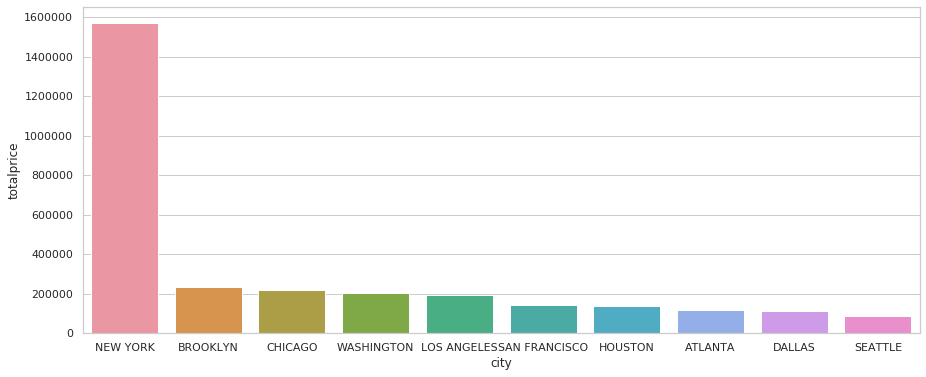

In [58]:
plt.figure(figsize=(15,6))
_ =sns.barplot(x="city", y = 'totalprice', data = city_totalprice_gr)#.set(yscale="log")

## Karty kredytowe

Na wykresie poniże widać jak popularne są karty kredytowe i ich udział w zakupach z podziałem na płeć.
Zarówno wśród kobiet i mężczyzn nabardziej popularną kartą test $VI$. Kobiety rzadziej używają kart $MC$ i $AE$ niż mężczyźni.
Najmniej popularne karty to $DB$ i $OC$.

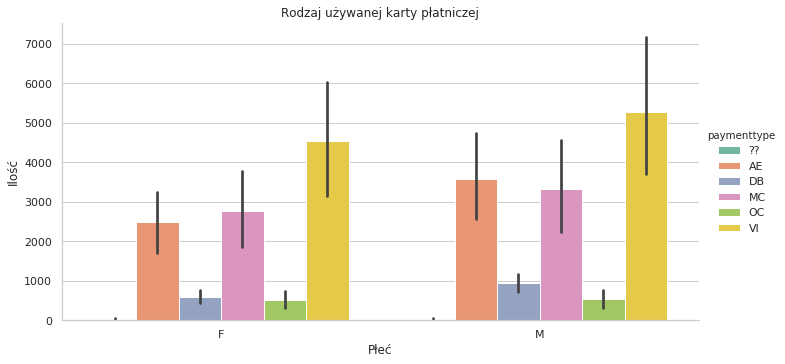

In [59]:
#Rodzaj używanej karty płatniczej - podział we względu na płeć
gender_pay_typ = customers_and_orders[["orderid","gender","paymenttype",'year']]
plot_pay_g = gender_pay_typ.groupby(["paymenttype","gender",'year']).agg({"orderid" : "count"}).rename(columns={'orderid': 'count'}).sort_values(by =["paymenttype","gender",'year'])
plot_pay_g_index = plot_pay_g.reset_index()

_ =sns.catplot(x= "gender", data = plot_pay_g_index, y="count", hue = "paymenttype",kind="bar",aspect=2)\
.set(title ='Rodzaj używanej karty płatniczej', ylabel = 'Ilość', xlabel = 'Płeć')

#### Rodzaje płatności i ich udział w zakupach w kolejnych latach

Poddano analizie rodzaje płatności oraz ich udział w zakupach w latach $2009-2016$. Największą popularnością cieszyły się karty $VI$, a najmniejszą $OC$. W stosunku do sumy rodzajów płatności stałym zainteresowaniem cieszą się płatności typu $AE$ oraz $MC$. Płatność lkartą $DB$ była popularna w latach $2009 - 2011$ działalności firmy, poczym zauważenie spadła do $2016$ roku.


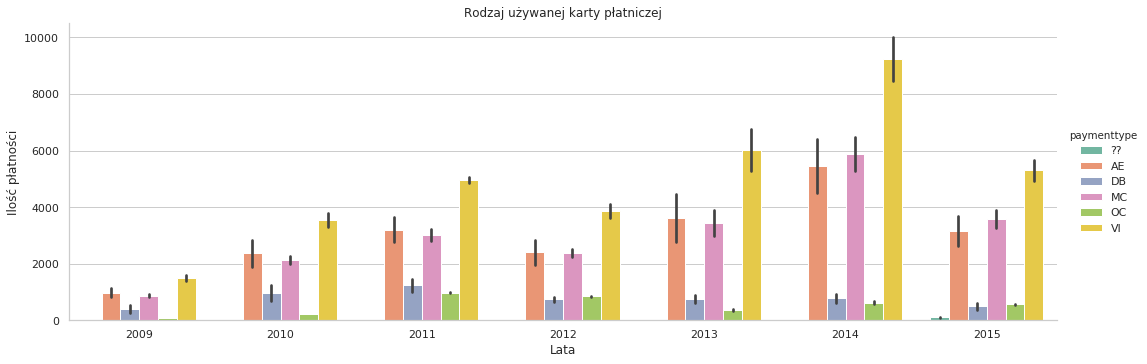

In [61]:
#ilość płatności poszczególnymi kartami w latach 2009-2016
_ =sns.catplot(x= "year", data = plot_pay_g_index, y="count", hue = "paymenttype",kind="bar",aspect=3)\
.set(title ='Rodzaj używanej karty płatniczej', ylabel = 'Ilość płatności', xlabel = 'Lata')

Największą ilość płatności odnotowana kartą $VI$.

In [62]:
#Karty kredytowe popularność tabela
pay_typ = customers_and_orders.groupby('paymenttype').orderid.count().sort_values(ascending=False)
pay_typ_df = pd.DataFrame(pay_typ).reset_index()
tabela_karty = pay_typ_df.rename(columns={'orderid': 'ilość płatności','paymenttype': 'rodzaj karty'})
tabela_karty.groupby('rodzaj karty').head(6)

,rodzaj karty,ilość płatności
0,VI,68824
1,MC,42564
2,AE,42379
3,DB,10744
4,OC,7402
5,??,267


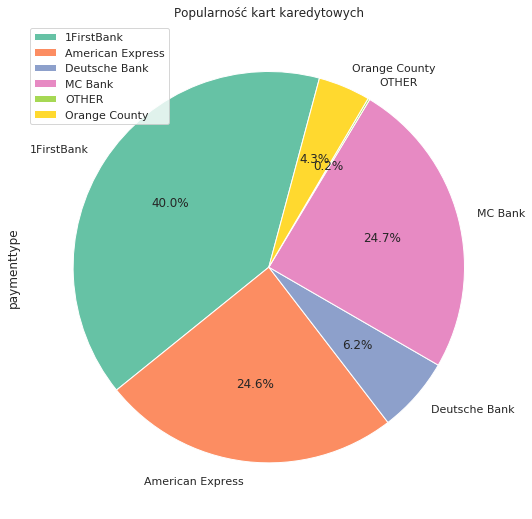

In [63]:
#popularność kart kredytowych procentowo
#z poszukiwań w internecie uzyskałem prawdopodobne nazwy banków oferujące poszczególne karty
karty = {"1FirstBank":customers_and_orders.paymenttype[customers_and_orders.paymenttype == "VI"].count(),
        "MC Bank":customers_and_orders.paymenttype[customers_and_orders.paymenttype == "MC"].count(),
        "American Express":customers_and_orders.paymenttype[customers_and_orders.paymenttype == "AE"].count(),
        "Deutsche Bank":customers_and_orders.paymenttype[customers_and_orders.paymenttype == "DB"].count(),
        "Orange County":customers_and_orders.paymenttype[customers_and_orders.paymenttype == "OC"].count(),
        "OTHER":customers_and_orders.paymenttype[customers_and_orders.paymenttype == "??"].count()}

karty_df = pd.DataFrame({"paymenttype": karty})
karty_df.plot.pie(subplots=True,  figsize=(9,9),  autopct='%1.1f%%',startangle=75)
_ = plt.title('Popularność kart karedytowych')

# Tabele

In [64]:
# ilości sprzedanych towarów - podział z uwzględnieniem kategorii produktów i lat
tab_prod_year = pd.pivot_table(BigData, values='numunits_x', index=['productgroupname'],\
                               columns=['year'],aggfunc={'numunits_x': np.sum}, fill_value='0',\
                               margins=True, margins_name='Sum')
tab_prod_year.sort_values(by=['Sum'], ascending=False, axis=0)

year,2009,2010,2011,2012,2013,2014,2015,2016,Sum
productgroupname,,,,,,,,,
Sum,15799,28881,62755.000,36353,48236,83762.000,79780.000,79809.000,435375
BOOK,7341.000,17854.000,26026.000,20801.000,27078.000,28574.000,27460.000,21719.000,176853
OCCASION,1334.000,3428.000,12111.000,4703.000,6664.000,12633.000,10555.000,23394.000,74822
ARTWORK,7091.000,5389.000,19128.000,5289.000,6154.000,8688.000,9194.000,6739.000,67672
FREEBIE,0,73.000,16.000,0,0,13593.000,17005.000,11788.000,42475
GAME,0,0,56.000,756.000,3500.000,8023.000,6177.000,8368.000,26880
APPAREL,16.000,71.000,265.000,1249.000,1433.000,7074.000,4460.000,2554.000,17122
CALENDAR,17.000,810.000,3747.000,3192.000,2563.000,2275.000,2602.000,973.000,16179
OTHER,0,1256.000,1406.000,363.000,844.000,2902.000,2327.000,4274.000,13372


In [65]:
# ilości sprzedanych towarów - TOP 10 miast, podział z uwzględnieniem kategorii produktów
sum_units = orderlines['numunits'].sum()
pd.reset_option("display.float_format")

tab_city_prod = pd.pivot_table(BigData, values='numunits_x', index=['city'],\
                               columns=['productgroupname'], aggfunc={'numunits_x': np.sum},\
                               fill_value='0', margins=True, margins_name='Sum')
tab_city_prod['Percent'] = tab_city_prod['Sum'] / sum_units * 100
tab_city_prod.sort_values(by=['Sum'], ascending=False, axis=0).head(11)

productgroupname,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER,Sum,Percent
city,,,,,,,,,,
Sum,17121,67665,176847,16179,42466,26876,74816,13372,435342,99.990353
NEW YORK,5195,9310,50932,3566,16800,9480,28157,7790,131230,30.141209
BROOKLYN,273,1293,4544,297,417,304,927,137,8192,1.881557
CHICAGO,200,815,1762,182,328,245,457,65,4054,0.931132
EDISON,15,986,150,19,19,10,2840,5,4044,0.928835
WASHINGTON,113,797,1592,118,276,187,396,72,3551,0.815602
LEBANON,4,32,3031,6,14,4,21,0,3112,0.714771
SAN FRANCISCO,143,557,1153,173,227,177,367,64,2861,0.657121
HOUSTON,81,528,1209,81,257,186,365,67,2774,0.637139


In [66]:
#sezonowość sprzedaży produktów 
tab_month_prod = pd.pivot_table(BigData, values='numunits_x', index=['productgroupname'],\
                                columns=['month'], aggfunc={'numunits_x': np.sum}, fill_value='0',\
                                margins=True, margins_name='Sum')
tab_month_prod .sort_values(by=['Sum'], ascending=False, axis=0)

month,1,2,3,4,5,6,7,8,9,10,11,12,Sum
productgroupname,,,,,,,,,,,,,
Sum,38459,25097,24294,19562,23358,33314,21995,68070,23773,23939,52678,80836,435375
BOOK,18035,10568,14818,10795,9075,9003,8817,14182,12003,10675,25671,33211,176853
OCCASION,4626,2406,1921,1954,4231,10710,6610,21473,3423,3929,4927,8612,74822
ARTWORK,9182,8604,3836,2949,3495,5093,3067,4345,2695,3162,9715,11529,67672
FREEBIE,1100,423,651,1218,3474,4456,1605,11794,1960,1377,5655,8762,42475
GAME,1433,789,1197,1152,1115,1648,832,6694,734,1457,2030,7799,26880
APPAREL,888,686,1214,1037,1520,1762,664,2827,2483,1353,829,1859,17122
CALENDAR,2233,334,418,143,205,190,109,2335,295,1253,2690,5974,16179
OTHER,962,1287,239,314,243,452,291,4420,180,733,1161,3090,13372


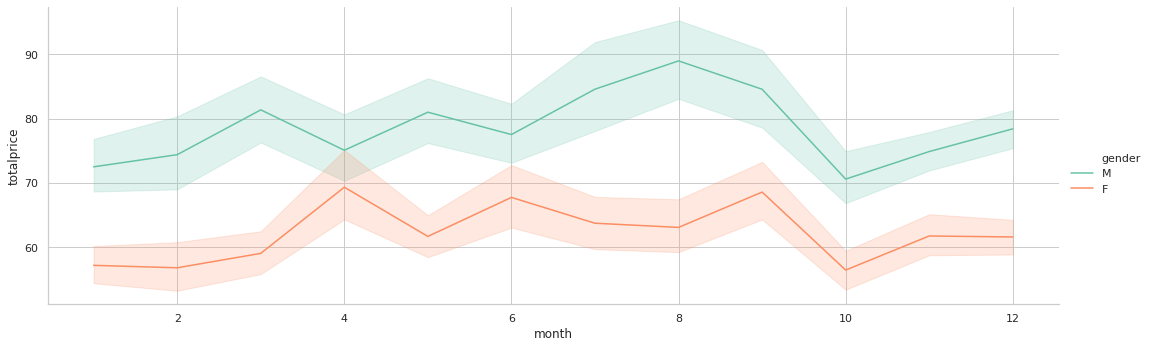

In [67]:
#sezonowość sprzedaży w kolejnych miesiącach z podziałem na płeć
_ = sns.relplot(y="totalprice", x="month", data =customers_and_orders, hue = 'gender', kind="line",aspect=3)

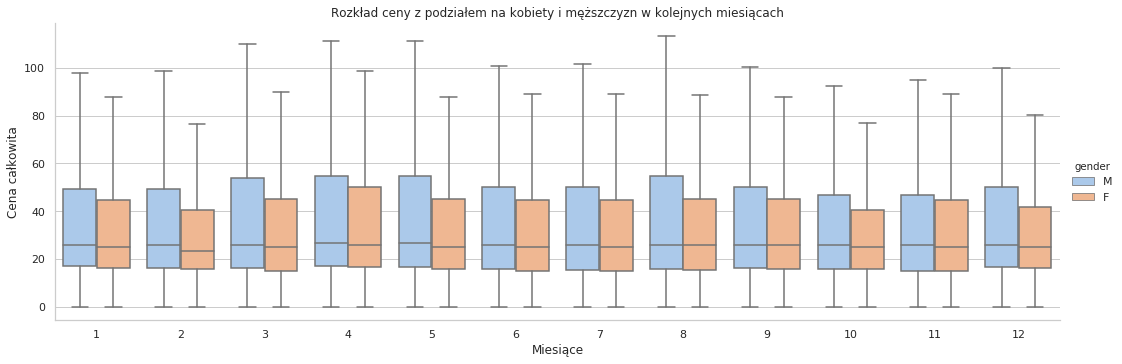

In [68]:
sns.set(style="whitegrid", palette="pastel")
_=sns.catplot(x ="month", y ="totalprice", kind="box",aspect=3,
            data =customers_and_orders, hue = 'gender', showfliers = False )\
.set(title = 'Rozkład ceny z podziałem na kobiety i męższczyzn w kolejnych miesiącach',\
     xlabel = 'Miesiące', ylabel = "Cena całkowita")

## Testy statystyczne

### Przy pomocy testu Shapiro-Wilka zbadam czy próba (ilość produktów w jednym zamówieniu) pochodzi z rozkładu normalnego

Przy pomocy testu Shapiro-Wilka możemy przetestować, czy dana próba $X = (x_1, \dots, x_n)$ pochodzi z rozkładu normalnego.
Formułujemy w tym celu hipotezę zerową i hipotezę alternatywną

$H_0$: „dane pochodzą z rozkładu normalnego”.

$H_1$: „dane nie pochodzą z rozkładu normalnego”.

$$\Large W=\frac{(\sum_{i=1}^{n}a_{i}x_{(i)})^2}{\sum_{i=1}^{n}(x_i-\overline{x})^2}$$


Jako miarę istotności wnioskowania, ustalamy poziom istotności $\alpha$ jako maksymalne prawdopodobieństwo popełnienia błędu pierwszego rodzaju, czyli odrzucenia $H_0$ mimo jej prawdziwości. Zazwyczaj przyjmujemy w tym celu wartość $\alpha=0.05$ lub mniejszą.

Wynikiem testu Shapiro-Wilka jest para liczb:
wartość statystyki testowej $W$ i p-wartość $p$, czyli prawdopodobieństwo otrzymania naszych (lub bardziej ekstremalnych) danych z rozkładu normalnego.

Hipotezę zerową możemy odrzucić jeżeli $p<α$.

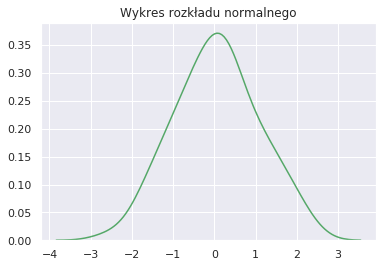

In [69]:
#wykres rozkładu normalnego
sns.set(); np.random.seed(0)
g = np.random.randn(100)
ax = sns.distplot(g, hist=False, color ='g').set(title = "Wykres rozkładu normalnego")

In [70]:
#dane do testu to ilość produktów w jednym zamówieniu
pd.set_option('float_format', '{:.3f}'.format)
test_dane = BigData[[ 'orderid', 'numunits_x']]

test_dane_gr = test_dane.groupby(by = 'orderid').sum()
lista = test_dane_gr['numunits_x'].tolist()

In [71]:
#ponieważ test Shapiro-Wilka sprawda się w próbach N < 500,
#niekiedy w literaturze podawana jest nawet wartość N < 100
#na potrzeby przeprowadzenie testu wybiorę losowo z całej próby 500 przypadków
lista2 = random.sample(lista, 500)
alpha = 0.05
X = lista2

W, p = scipy.stats.shapiro(X)

if (p < alpha) :
  print("p < alpha \nDane nie pochodzą z rozkładu normalnego.")
else :
  print( "Nie można odrzucić hipotezy o normalności rozkładu.")
print("W=",W," ","p=",p)


p < alpha 
Dane nie pochodzą z rozkładu normalnego.
W= 0.5477644205093384   p= 6.847605864312629e-34


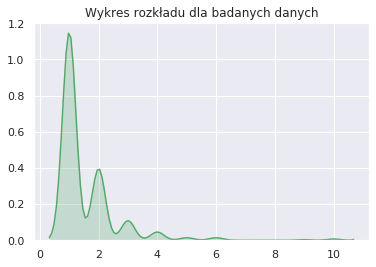

In [72]:
_= sns.kdeplot(lista2, shade=True, color ='g').set(title = "Wykres rozkładu dla badanych danych")

Test potwierdza:
$H_1$: „dane nie pochodzą z rozkładu normalnego”.

### Test Kołmogorowa-Smirnowa

Stosowany alternatywnie do testu Shapiro-Wilka przy prubach większych.

Przy pomocy testu Kołmogorowa-Smirnowa możemy przetestować, czy dana próba $X = (x_1, \dots, x_n)$ pochodzi ze wskazanego, znanego rozkładu. Działamy podobnie jak w teście Shapiro-Wilka.

$$\Large K_n = \sup_{x} |(F_{n}-F) (x)|$$


Wynikiem testu Kołmogorowa-Smirnowa jest para liczb:
wartość statystyki testowej $D$ i p-wartość $p$, czyli prawdopodobieństwo otrzymania naszych (lub bardziej ekstremalnych) danych ze wskazanego rozkładu.
Hipotezę zerową możemy odrzucić jeżeli $p<α.$

In [73]:
#dane do testu Kołmogorowa-Smirnowa to wszystkie zamówienie i liczba artykułów w jednym zamówieniu

alpha = 0.05
x = lista
D, p = kstest(x, 'norm', args=(np.mean(x),np.std(x,ddof=1)))

if (p < alpha) :
  print("Dane nie pochodzą z rozkładu normalnego.")
else :
  print ("Nie można odrzucić hipotezy o normalności rozkładu")
print("D=",D," ","p=",p)

Dane nie pochodzą z rozkładu normalnego.
D= 0.4920948579752706   p= 0.0


__________________________________________________________________________________________________________________

### Podsumowanie

W przedsiębiorstwie $XXX$ większość klientów, a co za tym idzie zamówień, stanowią mężczyźni. Jest to jednak stosunek około $55$% do $45$%. Największą popularnością cieszą się produkty z grupy $BOOK$ i $ARTWORK$, z których te drugie przynoszą największe zyski dla firmy. Zdecydowanie największą sprzedaż firma $XXX$ posiada w Nowym Jorku, w którym sprzedaż produktów znacznie przewyższa punkty z innych miast. W $2014$ roku przedsiębiorstwo osiągneło najwyższą sprzedaż a co za tym idzie zyski, które , niestyty, w kolejnych dwóch latach zaczęły spadać. 
Analiza wyników sprzedaży pozwala na wyciąganie wniosków przez zarząd firmy $XXX$ dotyczących m.in.: pracy handlowców i systemów motywacyjnych, produktów, klientów oraz systemu planowania. Analiza struktury klientów jest równie ważna jak analiza produktów. Dzięki niej zarząd może ocenić, którzy klienci najbardziej przyczyniają się do wzrostu poziomu sprzedaży oraz jej rentowności.
Warto zwrócić również uwagę na lokalizacę najwyższej sprzedaży. $Nowy York$ nie jest miastem o wiele większym niż $Los$ $Angeles$ czy $Chicago$. Tym bardziej zastanawiająca jest zatrważająca przewaga w sprzedaży.